# BCycle Austin stations

This notebook looks at the stations that make up the Austin BCycle network. For each station we have the following information:

* `station_id`: A unique identifier for each of the station. Used to connect the `bikes.csv` time-varying table to the static `stations` table.
* `name`: The name of the station. This is the nearest cross street to the station, or if the station is located at a building, the name of that building.
* `address`: The address of the station. Note that if a company sponsors the station, it will include their name, for example 'Presented by Whole Foods Market'. For this reason, its best not to geocode this field to a lat/lon pair, and use those values from the respective fields.
* `lat`: The latitude of the station.
* `lon`: The longitude of the station.
* `datetime`: The date and time that the station was first reported when fetching the BCycle Station webpage.

## Imports and data loading

Before getting started, let's import some useful libraries (including the bcycle_lib created for these notebooks), and load the stations CSV file.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
import seaborn as sns

from bcycle_lib.utils import *

%matplotlib inline

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
# Load the stations table, and show the first 10 entries
stations_df = load_stations()
num_stations = stations_df.shape[0]
print('Found {} stations, showing first 10'.format(num_stations))
stations_df.head(10)


Found 50 stations, showing first 10


,station_id,name,address,lat,lon,datetime
0,1,2nd & Congress,"151 E. 2nd St, Austin, TX 78701",30.264080,-97.743553,2016-04-01
1,2,4th & Congress,"120 W. 4th St., Austin, TX 78701",30.266340,-97.743782,2016-04-01
2,3,8th & Congress,"111 E. 8th St., Austin, TX 78701",30.269800,-97.741859,2016-04-01
3,4,Capitol Station / Congress & 11th,"1090 Congress Ave., Austin, TX 78701",30.272600,-97.741272,2016-04-01
4,5,City Hall / Lavaca & 2nd,"Presented by Graves Dougherty Hearon & Moody, ...",30.264759,-97.746780,2016-04-01
5,6,5th & Bowie,"Presented by Whole Foods Market, Austin, TX 78703",30.269600,-97.753319,2016-04-01
6,7,Barton Springs & Riverside,"400 Barton Springs Rd., Austin, TX 78704",30.258699,-97.748718,2016-04-01
7,8,South Congress & James,"Presented by The Austin Chronicle, Austin, TX ...",30.251030,-97.749260,2016-04-01
8,9,South Congress & Elizabeth,"101 Elizabeth St. W, Austin, TX 78704",30.248911,-97.750191,2016-04-01
9,10,Waller & 6th St.,"602 Waller St., Austin, TX 78702",30.264610,-97.730492,2016-04-01


## Plot the stations on a map of Austin

Let's plot all the stations on an Open Street Map of Austin, to see where they're concentrated. 

As you'd expect, there are a large cluster of stations in the downtown area. Austin's downtown is a mixture of residential and business buildings, so this could be for commute start and end points. 

There's also a line of stations extending east from the downtown area, along East 5th Street (east of I-35). This also follows the light rail line, which allows people to take the train into Austin, and complete the last mile or two on a bike if their work is further than walking distance from a station.

The UT Austin campus has its own cluster of stations, as it's a short ride from the downtown area, and students may use it to cycle downtown.

Finally, there are stations clustered in and around Zilker park, and the Town Lake cycle and footpath. People might use these bikes recreationally. There is also a set of stations extending on South Congress, where car parking is a known problem, and there are a lot of restaurants and stores.

In [3]:
# First find the minimum and maximum lat/lon values for each of the stations
min_lat = stations_df['lat'].min()
max_lat = stations_df['lat'].max()
min_lon = stations_df['lon'].min()
max_lon = stations_df['lon'].max()

center_lat = min_lat + (max_lat - min_lat) / 2.0
center_lon = min_lon + (max_lon - min_lon) / 2.0

# create empty map zoomed in on San Francisco
map = folium.Map(location=(center_lat, center_lon), 
                 zoom_start=14, 
                 tiles='Stamen Toner',
                 control_scale=True)

for station in stations_df.iterrows():
    folium.Marker([stat['lat'], stat['lon']],
              popup=stat['name'],
              icon=folium.Icon(icon='info-sign')
             ).add_to(map)
map

## Station bike capacity histogram

Now we've visualized where each station in the system is, let's show how many combined bikes and docks each of the stations has (their capacity). To do this we need to load in the bikes dataframe, and calculate the maximum of `bikes + docks` for each of the stations across the data.

Then let's plot a histogram, to see how many different capacities there are, and if there are any outliers. It looks like the most common capacity is 13.

Smallest stations: 
                          name  capacity
26            5th & San Marcos         9
42           East 4th & Chicon         9
48             Republic Square         9
7       South Congress & James         9
46  East 7th & Pleasant Valley        10

Largest stations: 
                                        name  capacity
25                    Davis at Rainey Street        17
28             Pfluger Bridge @ W 2nd Street        17
3          Capitol Station / Congress & 11th        18
4                   City Hall / Lavaca & 2nd        19
45  MoPac Pedestrian Bridge @ Veterans Drive        19



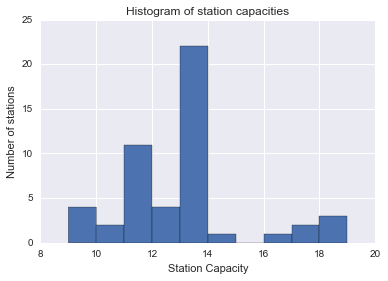

In [4]:
# Load bikes dataframe, calculate the capacity of each every 5 minutes (bikes + docks)
bikes_df = load_bikes()
bikes_df['capacity'] = bikes_df['bikes'] + bikes_df['docks']

# Now find the max capacity across all the stations at all 5 minute intervals
bikes_df = bikes_df.groupby('station_id').max().reset_index()
bikes_df = bikes_df[['station_id', 'capacity']]
# print(bikes_df.shape)
# bikes_df.head()

# Now join with the stations dataframe using station_id
stations_cap_df = pd.merge(stations_df, bikes_df, on='station_id')
# print(stations_cap_df.shape)
# stations_cap_df.head()

# Print the smallest and largest stations
sorted_stations = stations_cap_df.sort_values(by='capacity', ascending=True)
print('Smallest stations: \n{}\n'.format(sorted_stations[['name', 'capacity']][:5]))
print('Largest stations: \n{}\n'.format(sorted_stations[['name', 'capacity']][-5:]))



# Show a histogram of the capacities
fig = plt.figure()

ax1 = stations_cap_df['capacity'].plot.hist()
ax1.set_xlabel('Station Capacity')
ax1.set_ylabel('Number of stations')
ax1.set_title('Histogram of station capacities')

## Station bike capacity and location

Now we can plot the bike stations using their capacity as the radius of each circle marker. For proper quantitative evaluation of the stations, we should take the square root of the radius so the areas of the circles are proportional to the capacity. But not doing this helps distinguish between the narrow range of capacities.

In [5]:
# Now plot each station as a circle whose area represents the capacity
map = folium.Map(location=(center_lat, center_lon), 
                 zoom_start=14, 
                 tiles='Stamen Toner',
                 control_scale=True)

# Hand-tuned values to make differences between circles larger
K = 0.5 
P = 2

# You should use area, not radius to scale circles proportionally,
# but using radius here helps show the differences in capacity
for station in stations_cap_df.iterrows():
    folium.CircleMarker([stat['lat'], stat['lon']],
                        radius= K * (stat['capacity'] ** P), # Scale circles to show difference
                        popup='{} - capacity {}'.format(stat['name'], stat['capacity']),
                        fill_color='blue',
                        fill_opacity=0.8
                       ).add_to(map)
map

## Station health

For more insight into the stations and their characteristics, we can define a metric of station 'health'. When bike stations have no bikes available, customers can't start a journey from that location. If they have no docks available, they can't end a trip at that station. So if we count how many 5-minute periods a station is full or empty, this can give us a guide to its health.

We need to aggregate the station information by time. We have time series data on the bikes and docks available, sampled every 5 minutes. We should also filter the bike data by hour-of-day so that if a station is empty or full overnight (when no-one is making any trips) it doesn't skew the results.

In [135]:
# Load both the bikes and station dataframes
bikes_df = load_bikes()
stations_df = load_stations()

## Empty/Full station health

Now we have a list of all the bike measurements where the station was empty or full, let's aggregate by station_id and count the results. This will tell us for every station, how many 5-minute intervals it was either full or empty. This is a good indicator of an un-healthy station. Let's merge the station names so the graph makes sense.

In [118]:
# Using the bikes and stations dataframes, mask off so the only rows remaining
# are either empty or full cases from 6AM onwards
bike_empty_mask = bikes_df['bikes'] == 0
bike_full_mask = bikes_df['docks'] == 0
bike_hour_mask = bikes_df['datetime'].dt.hour >= 6
bike_empty_full_mask = (bike_empty_mask | bike_full_mask) & bike_hour_mask

bikes_empty_full_df = bikes_df[bike_empty_full_mask]
bikes_empty_full_df['empty'] = bikes_empty_full_df['bikes'] == 0
bikes_empty_full_df['full'] = bikes_empty_full_df['docks'] == 0
bikes_empty_full_df.head()

/Users/tim/anaconda/envs/ds450_env/lib/python3.5/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/tim/anaconda/envs/ds450_env/lib/python3.5/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,station_id,datetime,bikes,docks,empty,full
3474,19,2016-04-01 06:00:00,13,0,False,True
3477,22,2016-04-01 06:00:00,0,13,True,False
3488,33,2016-04-01 06:00:00,0,13,True,False
3492,37,2016-04-01 06:00:00,11,0,False,True
3493,38,2016-04-01 06:00:00,13,0,False,True


## Station empty-full barchart

This chart shows how many 5-minute periods each station was either empty or full in both April and May 2016.

The 

In [119]:
# Now aggregate the remaining rows by station_id, and plot the results
bike_health_df = bikes_empty_full_df.copy()
bike_health_df = bike_health_df[['station_id', 'empty', 'full']].groupby('station_id').sum().reset_index()
bike_health_df = pd.merge(bike_health_df, stations_df, on='station_id')
# bike_health_df.sort_values(by='count', ascending=False)[['name', 'count']].head(10)
bike_health_df.head()

,station_id,empty,full,name,address,lat,lon,datetime
0,1,476.0,673.0,2nd & Congress,"151 E. 2nd St, Austin, TX 78701",30.264080,-97.743553,2016-04-01
1,2,1043.0,462.0,4th & Congress,"120 W. 4th St., Austin, TX 78701",30.266340,-97.743782,2016-04-01
2,3,337.0,212.0,8th & Congress,"111 E. 8th St., Austin, TX 78701",30.269800,-97.741859,2016-04-01
3,4,508.0,4.0,Capitol Station / Congress & 11th,"1090 Congress Ave., Austin, TX 78701",30.272600,-97.741272,2016-04-01
4,5,64.0,449.0,City Hall / Lavaca & 2nd,"Presented by Graves Dougherty Hearon & Moody, ...",30.264759,-97.746780,2016-04-01


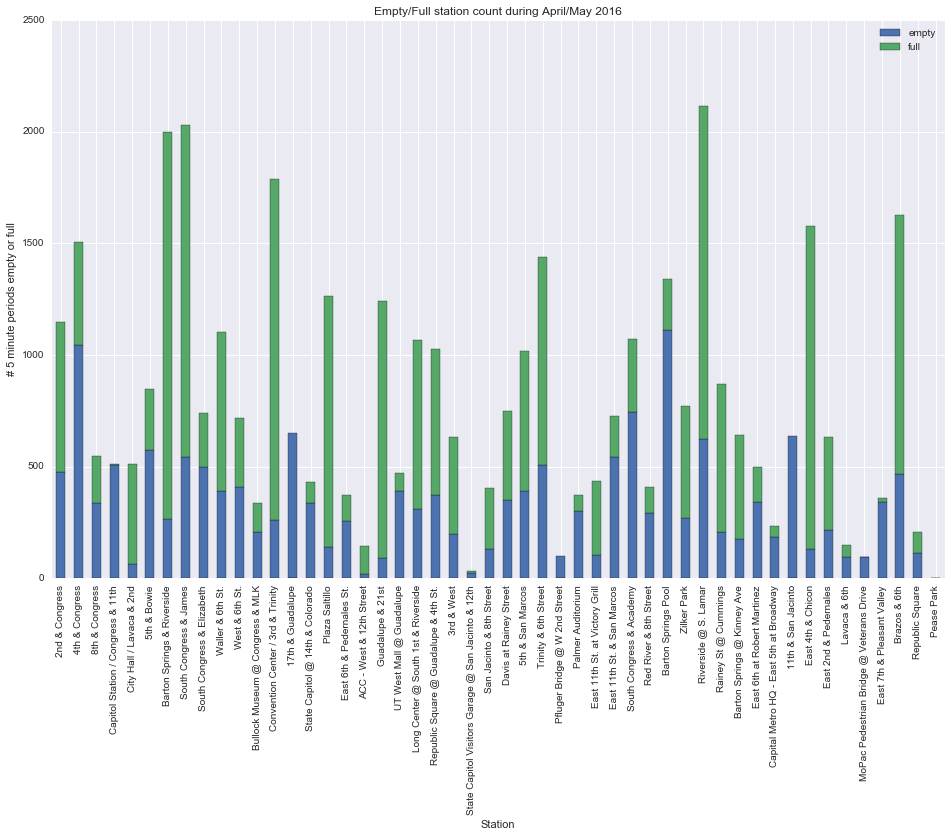

In [136]:
ax1 = (bike_health_df[['name', 'empty', 'full']]
       .plot.bar(x='name', y=['empty', 'full'], stacked=True, figsize=(16,10)))
ax1.set_xlabel('Station')
ax1.set_ylabel('# 5 minute periods empty or full')
ax1.set_title('Empty/Full station count during April/May 2016')

## Stations empty / full based on their location

From the bar chart above, there is a wide variation in the amount of 5 minute intervals when stations are empty or full. There is also a lot of variation in which stations are full or empty for each of those 5 minute periods. Let's investigate which stations are mostly full or empty, and if there's a spatial component to this.

In the map below, the circle markers use both colour and size as below:

* The colour of the circle shows whether the station is more frequently full (red), or more frequently empty (blue).
* The size of the circle shows how strongly biased the station is to being either frequently full or empty. A larger circle means it has a lot fo 5 minute intervals when the station is either empty or full.

In [134]:
# For this plot, we don't want to mask out the time intervals where stations are neither full nor empty.
station_ratio_df = bikes_df.copy()
station_ratio_df = station_ratio_df[station_ratio_df['datetime'].dt.hour >= 6]
station_ratio_df['empty'] = station_ratio_df['bikes'] == 0
station_ratio_df['full'] = station_ratio_df['docks'] == 0
station_ratio_df['neither'] = (station_ratio_df['bikes'] != 0) & (station_ratio_df['docks'] != 0)

station_ratio_df = station_ratio_df[['station_id', 'empty', 'full', 'neither']].groupby('station_id').sum().reset_index()
station_ratio_df['total'] = station_ratio_df['empty'] + station_ratio_df['full'] + station_ratio_df['neither']
station_ratio_df = pd.merge(station_ratio_df, stations_df, on='station_id')

station_ratio_df['full_ratio'] = station_ratio_df['full'] / station_ratio_df['total']
station_ratio_df['empty_ratio'] = station_ratio_df['empty'] / station_ratio_df['total']
station_ratio_df['oos_ratio'] = station_ratio_df['full_ratio'] + station_ratio_df['empty_ratio']

map = folium.Map(location=(center_lat, center_lon), 
                 zoom_start=14, 
                 tiles='Stamen Toner',
                 control_scale=True)

# Hand-tuned parameter to increase circle size
K = 1000

for station in station_ratio_df.iterrows():
    stat = station[1]
    
    folium.CircleMarker([stat['lat'], stat['lon']],
                        radius=stat['oos_ratio'] * K,
                        popup='{}, empty {}, full {}'.format(stat['name'], stat['empty'], stat['full']),
                        fill_color=station_colour,
                        fill_opacity=0.8
                       ).add_to(map)
map

This map shows that the stations that are frequently full or empty, and therefore out-of-service as larger radius circles. Stations which are not frequently unavailable are smaller dots. The map shows that stations most frequently unavailable can be grouped into 3 clusters:

1. The downtown area around East 6th Street between Congress and I-35 and Red River street. This area has a large concentration of businesses, restaurants and bars. 
2. South of the river along the Town Lake hiking and cycling trail along with South Congress. The Town Lake trail is a popular cycling route, and there are many restaurants and bars on South Congress.
3. Stations along East 5th Street, near the downtown area. This area has a lot of bars and restaurants, people may be using BCycles to get around to other bars.

## Correlation between station empty/full and station capacity

Perhaps the reason stations are empty or full a lot is because they have a smaller capacity. Smaller stations would quickly run out of bikes, or become more full. Let's do a hypothesis test:

Null hypothesis: The capacity of the station is not correlated with the empty/full count.

Alternative hypothesis: The capacity of the station is correlated with the empty/full count.



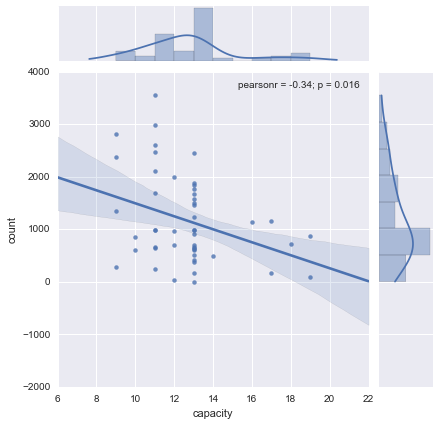

In [11]:
bikes_capacity_df = bikes_df.copy()
bikes_capacity_df['capacity'] = bikes_capacity_df['bikes'] + bikes_capacity_df['docks']

# Now find the max capacity across all the stations at all 5 minute intervals
bikes_capacity_df = bikes_capacity_df.groupby('station_id').max().reset_index()


bike_merged_health_df = pd.merge(bike_health_df, bikes_capacity_df[['station_id', 'capacity']], on='station_id', how='inner')

bike_merged_health_df.head(10)

# sns.lmplot(data=bike_merged_health_df, x='capacity', y='count')
g = sns.jointplot("capacity", "count", data=bike_merged_health_df, kind="reg")


## Station empty / full by Time

To break the station health down further, we can check in which 5 minute periods the station was either full or empty. By grouping the results over various time scales, we can look for periodicity in the data.

/Users/tim/anaconda/envs/ds450_env/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/tim/anaconda/envs/ds450_env/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


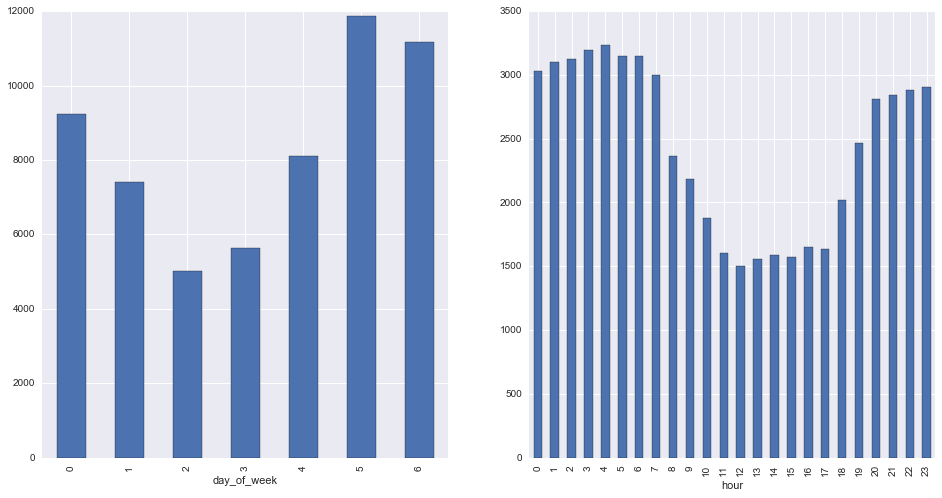

In [25]:
bikes_df = load_bikes()
empty_mask = bikes_df['bikes'] == 0
full_mask = bikes_df['docks'] == 0
empty_full_mask = empty_mask | full_mask
bikes_empty_full_df = bikes_df[empty_full_mask]
bikes_empty_full_df['day_of_week'] = bikes_empty_full_df['datetime'].dt.dayofweek
bikes_empty_full_df['hour'] = bikes_empty_full_df['datetime'].dt.hour

fig, axes = plt.subplots(1,2, figsize=(16,8))
bikes_empty_full_df.groupby(['day_of_week']).size().plot.bar(ax=axes[0])
bikes_empty_full_df.groupby(['hour']).size().plot.bar(ax=axes[1])
